# DATA LOADING

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Subset
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

path = './chest_xray/chest_xray'

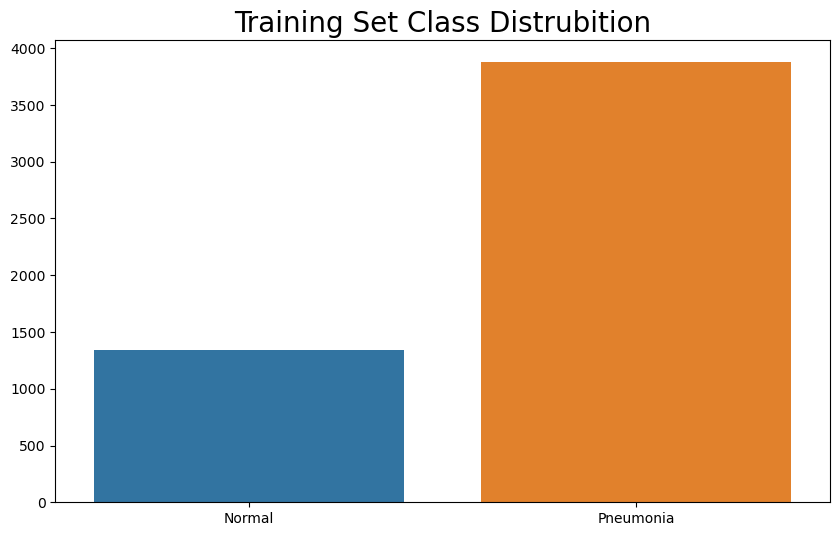

In [2]:
# Data visualization
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})

plt.figure(figsize=(10,6))
sns.barplot(data=train_samplesize)
plt.title('Training Set Class Distrubition', fontsize=20)
plt.show()

# DATA PREPROCESSING AND AUGMENTATION

In [4]:
# 299x299
transformer = {
    'dataset1': transform.Compose([
        transform.Resize((299, 299)),       
        transform.RandomHorizontalFlip(),
        transform.RandomRotation(10),
        transform.RandomGrayscale(),
        transform.RandomAffine(translate=(0.05,0.05), degrees=0),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'dataset2' : transform.Compose([
        transform.Resize((299, 299)),
        transform.RandomHorizontalFlip(p=1),
        transform.RandomGrayscale(),
        transform.RandomAffine(translate=(0.1,0.05), degrees=10),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
                                   
    'dataset3' : transform.Compose([
        transform.Resize((299, 299)),
        transform.RandomHorizontalFlip(p=0.5),
        transform.RandomRotation(15),
        transform.RandomGrayscale(p=1),
        transform.RandomAffine(translate=(0.08,0.1), degrees=15),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    # Test ve Val verisi için SADECE boyutlandırma ve normalizasyon
    'test': transform.Compose([
        transform.Resize((299, 299)),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

dataset1 = ImageFolder(path+'/train', transform=transformer['dataset1'])
dataset2 = ImageFolder(path+'/train', transform=transformer['dataset2'])
dataset3 = ImageFolder(path+'/train', transform=transformer['dataset3'])

# Class Balancing
dataset_len = len(dataset2)
indices = list(range(dataset_len))

split_idx1 = int(dataset_len * (1 - (3875/(1341+3875)))) 
norm1_indices = indices[:split_idx1]
norm1 = Subset(dataset2, norm1_indices)

split_idx2 = int(dataset_len * (1 - (4023/(1341+3875))))
norm2_indices = indices[:split_idx2]
norm2 = Subset(dataset3, norm2_indices)

train_dataset = ConcatDataset([dataset1, norm1, norm2])
test_dataset = ImageFolder(path+'/test', transform=transformer['test'])
val_dataset = ImageFolder(path+'/val', transform=transformer['test'])

# DataLoader
batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Validation Loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Test Loader

print(f"Training Data: {len(train_dataset)}")
print(f"Validation Data: {len(val_dataset)}")
print(f"Test Data: {len(test_dataset)}")

Training Data: 7750
Validation Data: 16
Test Data: 624


# Inception Model Initialization

In [5]:
# Transfer Learning
model = models.inception_v3(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

num_aux_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_aux_ftrs, 2)

model = model.to(device)

# Handling class imbalance -> Assiged higher weights to the 'Normal' class 
count_normal = 1341
count_pneumonia = 3875
total = count_normal + count_pneumonia
weight_normal = total / count_normal
weight_pneumonia = total / count_pneumonia

class_weights = torch.tensor([weight_normal, weight_pneumonia], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("Model is ready..")

Model is ready..


# MODEL TRAINING

In [6]:
def train_inception_model(model, train_loader, val_loader, optimizer, n_epochs=10, patience=3, model_name='best_model.pth'):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    print(f"Training started (Patience: {patience}) ---")

    for epoch in range(n_epochs):
        t0 = time.time()

        # TRAIN
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # VAL
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = 100 * correct_val / total_val
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.2f}%")
        
        # EARLY STOP and MODEL CHECKPOINT
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_name)
            print(f"   --> Best model saved (Val Loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"   --> No improvement. Counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("EARLY STOPPING")
                break
              
    model.load_state_dict(torch.load(model_name))
    return train_losses, val_losses, train_accs, val_accs

In [7]:
# Transfer Learning
params_to_update = list(model.fc.parameters()) + list(model.AuxLogits.fc.parameters())
optimizer = torch.optim.Adam(params_to_update, lr=0.0001, weight_decay=1e-4)

history = train_inception_model(
    model, train_loader, val_loader, optimizer, 
    n_epochs=10, patience=3, model_name='best_model_head.pth'
)

Training started (Patience: 3) ---
Epoch 1/10 | Train Loss: 0.6157 Acc: 61.33% | Val Loss: 0.4591 Acc: 62.50%
   --> Best model saved (Val Loss: 0.4591)
Epoch 2/10 | Train Loss: 0.4286 Acc: 78.77% | Val Loss: 0.3849 Acc: 75.00%
   --> Best model saved (Val Loss: 0.3849)
Epoch 3/10 | Train Loss: 0.3737 Acc: 83.24% | Val Loss: 0.4022 Acc: 75.00%
   --> No improvement. Counter: 1/3
Epoch 4/10 | Train Loss: 0.3424 Acc: 85.17% | Val Loss: 0.3319 Acc: 81.25%
   --> Best model saved (Val Loss: 0.3319)
Epoch 5/10 | Train Loss: 0.3257 Acc: 86.04% | Val Loss: 0.3242 Acc: 81.25%
   --> Best model saved (Val Loss: 0.3242)
Epoch 6/10 | Train Loss: 0.3156 Acc: 86.65% | Val Loss: 0.2874 Acc: 81.25%
   --> Best model saved (Val Loss: 0.2874)
Epoch 7/10 | Train Loss: 0.3047 Acc: 86.75% | Val Loss: 0.3148 Acc: 81.25%
   --> No improvement. Counter: 1/3
Epoch 8/10 | Train Loss: 0.2957 Acc: 87.77% | Val Loss: 0.2907 Acc: 81.25%
   --> No improvement. Counter: 2/3
Epoch 9/10 | Train Loss: 0.2898 Acc: 87.92

In [8]:
# Fine Tuning
for param in model.parameters():
    param.requires_grad = True

# Optimizer 
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
model = model.to(device)

history_ft = train_inception_model(
    model, train_loader, val_loader, optimizer_ft, 
    n_epochs=10, patience=3, model_name='best_model_finetuned.pth'
)

Training started (Patience: 3) ---
Epoch 1/10 | Train Loss: 0.1708 Acc: 93.73% | Val Loss: 0.1618 Acc: 100.00%
   --> Best model saved (Val Loss: 0.1618)
Epoch 2/10 | Train Loss: 0.0978 Acc: 96.66% | Val Loss: 0.0549 Acc: 100.00%
   --> Best model saved (Val Loss: 0.0549)
Epoch 3/10 | Train Loss: 0.0809 Acc: 97.50% | Val Loss: 0.0661 Acc: 100.00%
   --> No improvement. Counter: 1/3
Epoch 4/10 | Train Loss: 0.0679 Acc: 97.96% | Val Loss: 0.0641 Acc: 100.00%
   --> No improvement. Counter: 2/3
Epoch 5/10 | Train Loss: 0.0529 Acc: 98.45% | Val Loss: 0.0394 Acc: 100.00%
   --> Best model saved (Val Loss: 0.0394)
Epoch 6/10 | Train Loss: 0.0431 Acc: 98.74% | Val Loss: 0.1407 Acc: 93.75%
   --> No improvement. Counter: 1/3
Epoch 7/10 | Train Loss: 0.0345 Acc: 99.11% | Val Loss: 0.0680 Acc: 100.00%
   --> No improvement. Counter: 2/3
Epoch 8/10 | Train Loss: 0.0337 Acc: 99.17% | Val Loss: 0.1261 Acc: 93.75%
   --> No improvement. Counter: 3/3
EARLY STOPPING


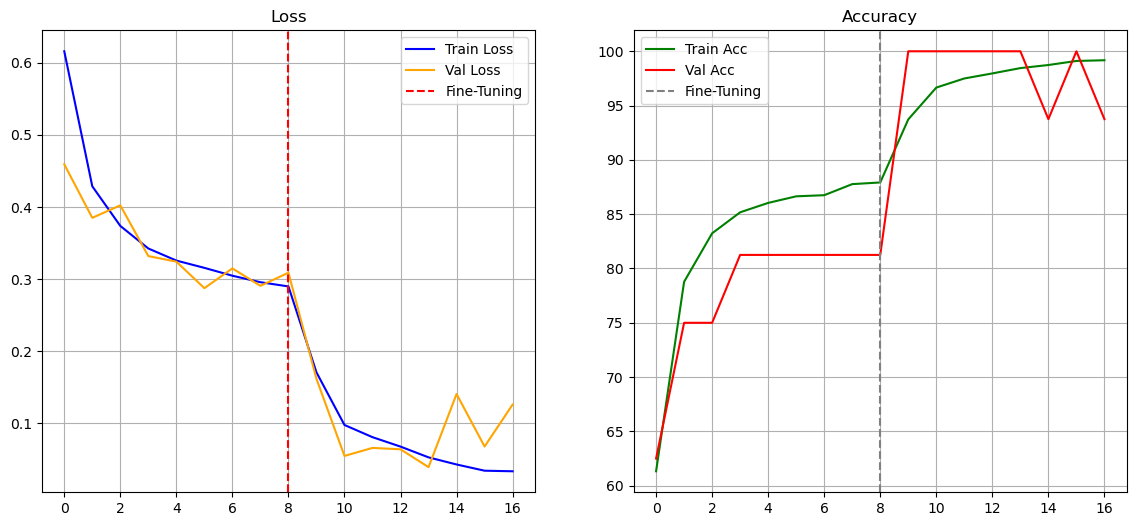

In [9]:
# Accuracy ve Loss Visualization

total_train_losses = history[0] + history_ft[0]
total_val_losses   = history[1] + history_ft[1]
total_train_accs   = history[2] + history_ft[2]
total_val_accs     = history[3] + history_ft[3]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(total_train_losses, label='Train Loss', color='blue')
plt.plot(total_val_losses, label='Val Loss', color='orange')
plt.axvline(x=len(history[0])-1, color='red', linestyle='--', label='Fine-Tuning')
plt.title('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(total_train_accs, label='Train Acc', color='green')
plt.plot(total_val_accs, label='Val Acc', color='red')
plt.axvline(x=len(history[0])-1, color='gray', linestyle='--', label='Fine-Tuning')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.show()

<Figure size 640x480 with 0 Axes>

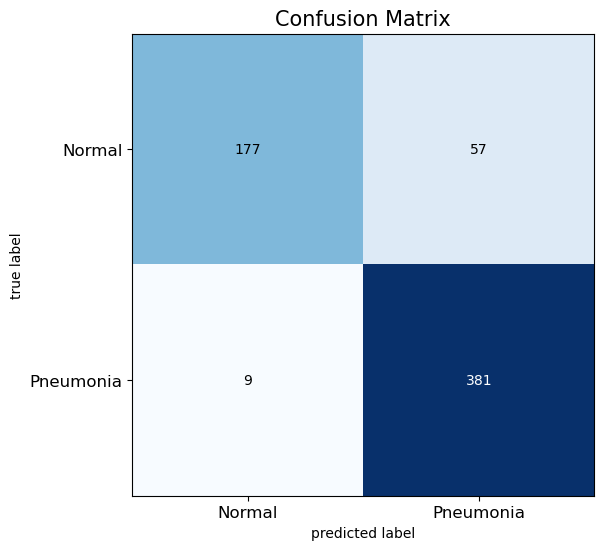

Accuracy  : 0.8942
Precision : 0.8699
Recall    : 0.9769
F1 Score  : 0.9203


In [10]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for inputs, labels in loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

preds, labels = get_all_preds(model, test_loader)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(8,6), cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

# Metrikler
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp+fp) > 0 else 0
recall = tp / (tp + fn) if (tp+fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision+recall) > 0 else 0

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

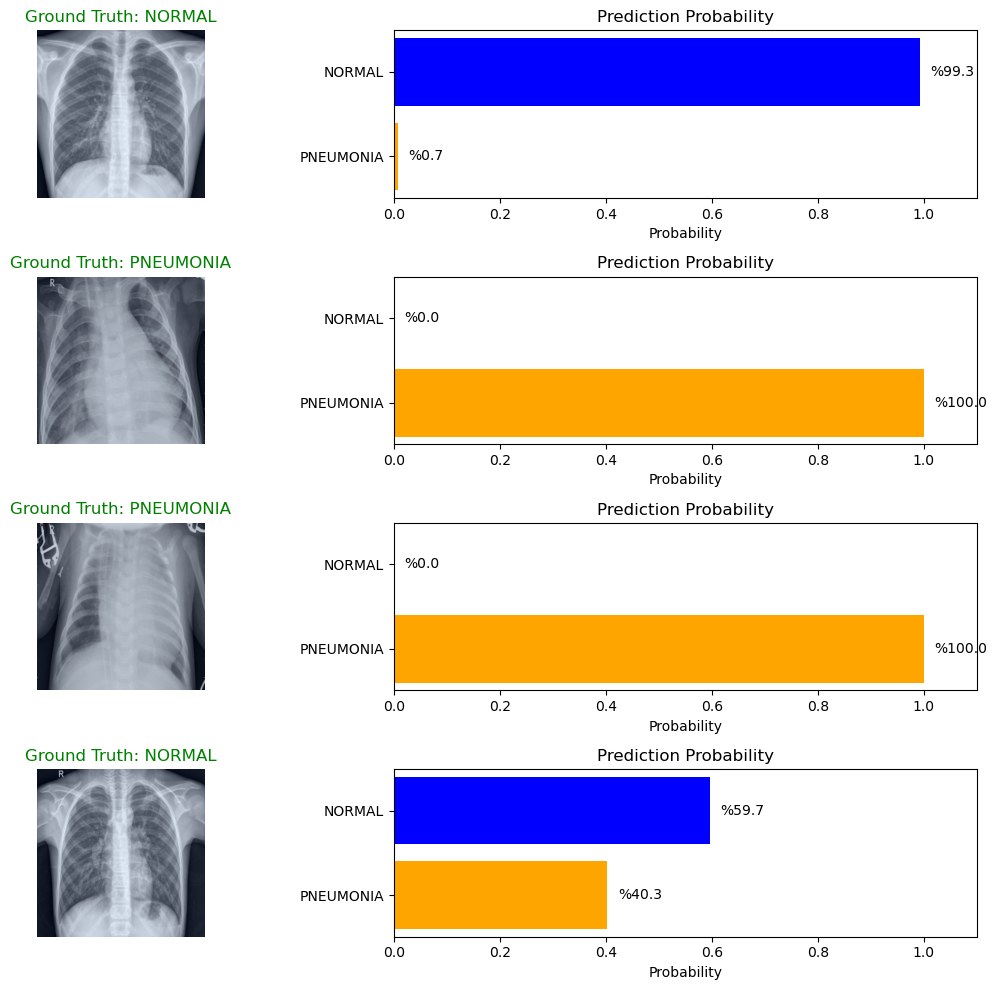

In [12]:
indices = np.random.choice(len(test_dataset), 4, replace=False)

fig, ax = plt.subplots(figsize=(12, 10), ncols=2, nrows=4)
class_names = ['NORMAL', 'PNEUMONIA']
y_pos = np.arange(len(class_names))

for i, idx in enumerate(indices):
    img, label = test_dataset[idx]

    model.eval()
    with torch.no_grad():
        logits = model(img.to(device).unsqueeze(0))
        probs = F.softmax(logits, dim=1).cpu().numpy().squeeze()

    img_display = img.permute(1, 2, 0).numpy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    ax[i][0].imshow(img_display)
    ax[i][0].set_title(f"Ground Truth: {class_names[label]}", color='green' if label == np.argmax(probs) else 'red')
    ax[i][0].axis('off')

    ax[i][1].barh(y_pos, probs, align='center', color=['blue', 'orange'])
    ax[i][1].set_yticks(y_pos)
    ax[i][1].set_yticklabels(class_names)
    ax[i][1].invert_yaxis()  
    ax[i][1].set_xlabel('Probability')
    ax[i][1].set_title('Prediction Probability')
    ax[i][1].set_xlim(0, 1.1)

    for j, v in enumerate(probs):
        ax[i][1].text(v + 0.02, j, f"%{v*100:.1f}", color='black', va='center')

plt.tight_layout()
plt.show()